In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

In [2]:
import cv2
import numpy as np

class image:
    def __init__(self, img_path: str) -> None:
        self.image_path = img_path
        
    def run(self) -> None:
        
        self.read_image()
        self.filled_curve = self.fill_closed_curves()
        self.skeleton = self.get_skeleton()
        self.skeleton_endpoints = self.skeleton_endpoints()
        print(f"Debug: {self.skeleton_endpoints}")
        self.path = self.bfs(tuple(self.skeleton_endpoints[0]), tuple(self.skeleton_endpoints[1]))
        self.targets = self.get_path_derivative()
    
    def read_image(self) -> None:
        temp = cv2.imread(self.image_path)
        temp = cv2.resize(temp, (640, 480))
        temp = cv2.GaussianBlur(temp, (5, 5), 0)
        self.image = temp
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.edges = cv2.Canny(self.gray, 50, 150, apertureSize=3)
    
    def fill_closed_curves(self) -> np.ndarray:
        # 形态学膨胀操作来闭合曲线
        kernel = np.ones((3, 3), np.uint8)
        dilated_edges = cv2.dilate(self.edges, kernel, iterations=1)

        # 寻找轮廓并填充
        contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled_image = np.zeros_like(self.edges)
        cv2.drawContours(filled_image, contours, -1, 255, thickness=cv2.FILLED)

        return filled_image

    def get_skeleton(self) -> np.ndarray:
        # 填充闭合曲线得到二值图像
        filled_edges = self.filled_curve

        # 结构元素
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

        # 细化操作，直到图像不再变化
        thin = filled_edges.copy()
        prev_thin = thin.copy()
        while True:
            cv2.morphologyEx(thin, cv2.MORPH_OPEN, kernel, iterations=2)
            skeleton = cv2.ximgproc.thinning(thin)
            if (prev_thin == skeleton).all():
                break
            prev_thin = skeleton.copy()

        return skeleton
    
    def skeleton_endpoints(self) -> np.ndarray:
        skel = self.skeleton.copy()
        skel[skel!=0] = 1
        skel = np.uint8(skel)

        # Apply the convolution.
        kernel = np.uint8([[1,  1, 1],
                        [1, 10, 1],
                        [1,  1, 1]])
        src_depth = -1
        filtered = cv2.filter2D(skel,src_depth,kernel)

        # Look through to find the value of 11.
        # This returns a mask of the endpoints, but if you
        # just want the coordinates, you could simply
        # return np.where(filtered==11)
        out = np.zeros_like(skel)
        out[np.where(filtered==11)] = 1
        out = np.argwhere(out > 0)
        return out

    # BFS 寻找路径函数
    def bfs(self, start: tuple, end: tuple) -> list:
        """
        Perform breadth-first search (BFS) algorithm to find the shortest path from the start point to the end point in a skeleton.
        Parameters:
        - start (tuple): The starting point coordinates (x, y) in the skeleton.
        - end (tuple): The ending point coordinates (x, y) in the skeleton.
        Returns:
        - list: The shortest path from the start point to the end point as a list of coordinates [(x1, y1), (x2, y2), ...].
            If no path is found, an empty list is returned.
        """
        skeleton = self.skeleton.copy()
        # 定义 8 邻域
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        
        # 队列初始化，存储当前位置和路径
        queue = deque([(start, [start])])
        
        # 访问过的节点
        visited = np.zeros(skeleton.shape, dtype=np.uint8)
        visited[start] = 1
        
        while queue:
            (x, y), path = queue.popleft()
            
            # 如果找到目标端点，返回路径
            if (x, y) == end:
                return path
            
            # 遍历 8 邻域
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                # 确保新位置在图像范围内并且是骨架的一部分且未访问
                if 0 <= nx < skeleton.shape[0] and 0 <= ny < skeleton.shape[1] and skeleton[nx, ny] == 255 and not visited[nx, ny]:
                    visited[nx, ny] = 1
                    queue.append(((nx, ny), path + [(nx, ny)]))  # 将路径延展
        
        # 如果无法到达，返回空路径
        return []


    def get_path_derivative(self, step: int = 10) -> dict:
        """
        Calculate the derivative of a path represented as a list of coordinates [(x1, y1), (x2, y2), ...].
        
        Parameters:
        - path (list): The input path as a list of coordinates [(x1, y1), (x2, y2), ...].
        - step (int): The step size for calculating the derivative (default: 10).
        
        Returns:
        - dict: A dictionary where the keys are points from the path and the values are the calculated derivatives.
        """
        path = self.path.copy()
        # 提前检查路径点的数量是否足够进行拟合

        if 2 * len(path) < 3:
            raise ValueError("The path is too short for quadratic fitting (requires at least 3 points).")

        derivatives = {}
        
        for i in range(step, len(path), step):
            # 处理边界问题，确保不会超出路径范围
            start_idx = max(0, i - step)
            end_idx = min(len(path), i + step)
            
            # 提取邻近点
            x = np.array([p[0] for p in path[start_idx:end_idx]])
            y = np.array([p[1] for p in path[start_idx:end_idx]])

            # 使用二次多项式拟合
            z = np.polyfit(x, y, 2)  # z[1] 是一次项的系数，即斜率
            
            # 对拟合的多项式求导：f'(x) = 2 * z[0] * x + z[1]
            current_x = path[i][0]
            slope = 2 * z[0] * current_x + z[1]
            
            # 存储当前点的斜率
            derivatives[path[i]] = slope
            
        return derivatives
            

Debug: [[ 65 380]
 [174 288]]


/var/folders/vf/71f3_2rj0gl_jbxb55mmyctm0000gn/T/ipykernel_14639/2391421598.py:148: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 2)  # z[1] 是一次项的系数，即斜率
/var/folders/vf/71f3_2rj0gl_jbxb55mmyctm0000gn/T/ipykernel_14639/2391421598.py:148: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 2)  # z[1] 是一次项的系数，即斜率
/var/folders/vf/71f3_2rj0gl_jbxb55mmyctm0000gn/T/ipykernel_14639/2391421598.py:148: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 2)  # z[1] 是一次项的系数，即斜率
/var/folders/vf/71f3_2rj0gl_jbxb55mmyctm0000gn/T/ipykernel_14639/2391421598.py:148: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 2)  # z[1] 是一次项的系数，即斜率
/var/folders/vf/71f3_2rj0gl_jbxb55mmyctm0000gn/T/ipykernel_14639/2391421598.py:148: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 2)  # z[1] 是一次项的系数，即斜率
/var/folders/vf/71f3_2rj0gl_jbxb55mmyctm0000gn/T/ipykernel_14639/2391421598.py:148: RankWarning: Polyfit may be poo

(-0.5, 639.5, 479.5, -0.5)

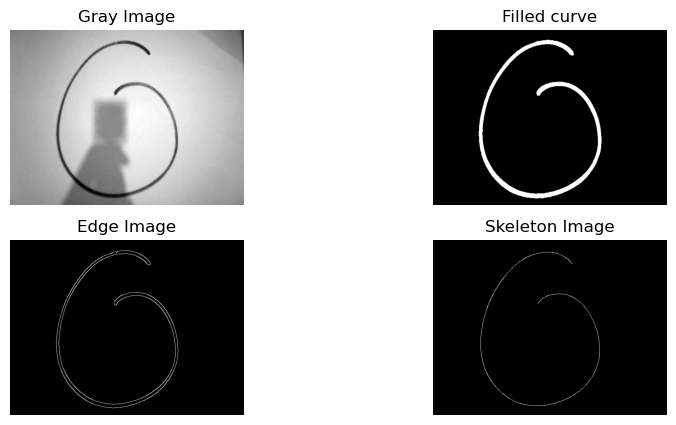

In [3]:
line_img = image('../images/captures/frame0.png')
line_img.run()

# 2*2的plot
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0, 1].imshow(line_img.filled_curve, cmap='gray')
axs[0, 1].set_title('Filled curve')
axs[0, 1].axis('off')

axs[0, 0].imshow(line_img.gray, cmap='gray')
axs[0, 0].set_title('Gray Image')
axs[0, 0].axis('off')

axs[1, 0].imshow(line_img.edges, cmap='gray')
axs[1, 0].set_title('Edge Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(line_img.skeleton, cmap='gray')
axs[1, 1].set_title('Skeleton Image')
axs[1, 1].axis('off')



